In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
np.random.seed(0)

In [27]:
class Logistic_Regression():
    
    def __init__(self, alpha = 0.01, it= 1000, regularization = 'l1', lmd = 0.4):
        self.alpha = alpha  
        self.it = it  
        self.regularization = regularization  
        self.lmd = lmd  
    
    def fit(self, X, Y):
        if X.shape[0] == 0 or X.shape[1] == 0:
            raise ValueError("Features can't be empty.")
        if Y.shape[0] == 0:
            raise ValueError("Labels can't be empty.")
        if X.shape[0] != Y.shape[0]:
            raise ValueError("Total row miamatch.")
        self.X = X
        self.Y = Y
        self.m, self.n = X.shape
        self.weight = np.zeros(self.n)
        self.bias = 0
        for _ in range(self.it):
            self._calc_weight_bias()
    
    def _calc_weight_bias(self):
        z = np.dot(self.X, self.weight) + self.bias
        Y_new = 1 / (1 + np.exp(-np.clip(z, -250, 250)))  
        dW = (1 / self.m) * np.dot(self.X.T, (Y_new - self.Y))
        db = (1 / self.m) * np.sum(Y_new - self.Y)
        if self.regularization == 'l2': 
            dW += (self.lmd / self.m) * self.weight
        elif self.regularization == 'l1':  
            dW += (self.lmd/ self.m) * np.sign(self.weight)
        self.weight -= self.alpha * dW
        self.bias -= self.alpha * db
    
    def predict(self, X):
        z = np.dot(X, self.weight) + self.bias
        Y_pred = 1 / (1 + np.exp(-np.clip(z, -250, 250)))  
        return np.where(Y_pred > 0.5, 1, 0)

    def predict_proba(self, X):
        z = np.dot(X, self.weight) + self.bias
        Y_proba = 1 / (1 + np.exp(-np.clip(z, -250, 250))) 
        return Y_proba


In [28]:
from sklearn.utils import resample
from scipy.stats import mode

class BaggingClassifier:
    
    def __init__(self, n_bags=9):
        self.n_bags = n_bags
        self.models = []
        self.m = None
    
    def fit(self, X, Y): 
        for i in range(self.n_bags):
            X_resampled, Y_resampled = resample(X, Y, replace=True)
            model = Logistic_Regression()  
            model.fit(X_resampled, Y_resampled)
            self.models.append(model)
    
    def predictMajority(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        Y_pred, _ = mode(predictions, axis=0, keepdims=False)
        return Y_pred.flatten()

    def stack_fit(self, X, Y):
        predV = np.array([model.predict(X) for model in self.models]).T  
        X_new = np.hstack((X, predV))
        self.m = Logistic_Regression(alpha=0.2,it=2000)
        self.m.fit(X_new, Y)

    def stack_predict(self, X):
        predV = np.array([model.predict(X) for model in self.models]).T 
        X_new = np.hstack((X, predV))
        Y_pred = self.m.predict(X_new)
        
        return Y_pred

    def evaluate_and_plot(self, X_test, y_test):
        predicts = [model.predict(X_test) for model in self.models]
        probabs = [model.predict_proba(X_test) for model in self.models]

        metrics = []
        for pred, prob in zip(predicts, probabs):
            accuracy = accuracy_score(y_test, pred)
            sensitivity = recall_score(y_test, pred, zero_division=1)
            specificity = recall_score(y_test, pred, pos_label=0, zero_division=1)
            precision = precision_score(y_test, pred, zero_division=1)
            f1 = f1_score(y_test, pred, zero_division=1)
            auroc = roc_auc_score(y_test, prob)
            aupr = average_precision_score(y_test, prob)
            metrics.append([accuracy, sensitivity, specificity, precision, f1, auroc, aupr])

        metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1-score', 'AUROC', 'AUPR'])

        for metric in metrics_df.columns:
            plt.figure(figsize=(8, 6))
            sns.violinplot(data=metrics_df[metric], inner="quartile")
            plt.title(f'Violin Plot of {metric} for Bagging LR Learners')
            plt.xlabel('Bagging LR Learners')
            plt.ylabel(metric)
            plt.show()

        comparative_df = metrics_df.agg(['mean', 'std']).T
        comparative_df['mean ± std'] = comparative_df['mean'].round(3).astype(str) + ' ± ' + comparative_df['std'].round(3).astype(str)
        print(comparative_df[['mean', 'std', 'mean ± std']])

    def predict_Majority_Proba(self, X):
        probas = np.array([model.predict_proba(X) for model in self.models])
        avg_probas = np.mean(probas, axis=0) 
        return avg_probas
        
    def stack_predict_proba(self, X):
        predV = np.array([model.predict_proba(X) for model in self.models]).T
        X_new = np.hstack((X, predV))
        Y_proba = self.m.predict_proba(X_new)
        return Y_proba 

In [29]:
csv = "WA_Fn-UseC_-Telco-Customer-Churn.csv"
d = 1
if d == 1:
    csv == "WA_Fn-UseC_-Telco-Customer-Churn.csv"
    df = pd.read_csv(csv)
    df = df.drop('customerID', axis=1)
elif d == 3:
    csv ="creditcard.csv"
    df = pd.read_csv(csv)
    class_0 = df[df['Class'] == 0]
    class_1 = df[df['Class'] == 1]
    class_0_sampled = class_0.sample(n=20000, random_state=42)
    balanced_df = pd.concat([class_0_sampled, class_1])
    df = balanced_df.reset_index(drop=True)
    
elif d == 2:
    
    with open('adult/adult.test', 'r') as test_file:
       lines = test_file.readlines()[1:]  

    with open('adult/adult1.test', 'w') as new_test_file:
        new_test_file.writelines(lines)

    df_test = pd.read_csv('adult/adult1.test', header=None) 
    df_data = pd.read_csv('adult/adult.data', header=None)  
    df_combined = pd.concat([df_data, df_test], ignore_index=True)
    df_combined.to_csv('combined_output.csv', index=False)
    df = pd.read_csv("combined_output.csv")
    df.replace(' <=50K.', ' <=50K', inplace=True)
    df.replace(' >50K.', ' >50K', inplace=True)
    # class_0 = df[df[df.columns[-1]] == ' <=50K']
    # class_1 = df[df[df.columns[-1]] == ' >50K']
    # class_0_sampled = class_0.sample(n=20000, random_state=42)
    # balanced_df = pd.concat([class_0_sampled, class_1])
    # df = balanced_df.reset_index(drop=True)
   



df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [30]:
df.shape

(7043, 20)

In [31]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [32]:
df.replace(' ?', np.nan, inplace=True)
#print(df.head(15))
df.isnull().sum()


gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [33]:
#df.fillna(df.mean(), inplace=True)


numeric_cols = df.select_dtypes(include='number').columns
non_numeric_cols = df.select_dtypes(exclude='number').columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean(numeric_only=True))
for col in non_numeric_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)
    
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [34]:
print(df.duplicated().sum())
if d == 2:
    print(df_data.duplicated().sum())
    print(df_test.duplicated().sum())
    df_data = df_data.drop_duplicates()
    df_test = df_test.drop_duplicates()
    train_size = df_data.shape[0]
    print(train_size)

22


In [35]:
df.drop_duplicates(keep='first', inplace=True)
df.duplicated().sum()

0

In [36]:
#for1
if d == 1:
    
    Features= df.drop('Churn', axis=1)
    Labels = df['Churn']
elif d == 3:
    Features= df.drop('Class', axis=1)
    Labels = df['Class']
elif d == 2:
    # df.replace(' <=50K.', ' <=50K', inplace=True)
    # df.replace(' >50K.', ' >50K', inplace=True)
    Features= df.drop(df.columns[-1], axis=1)
    Labels = df[df.columns[-1]]
Features.shape

(7021, 19)

In [37]:
label_counts = pd.Series(Labels).value_counts()
print(label_counts)

No     5164
Yes    1857
Name: Churn, dtype: int64


In [38]:
print(Features.dtypes)

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object


In [39]:
non_numerical_columns = Features.select_dtypes(include=['object']).columns
for col in non_numerical_columns:
    Features[col] = Features[col].astype('category')
normal_f = df.columns.tolist()
print(Features.dtypes)

gender              category
SeniorCitizen          int64
Partner             category
Dependents          category
tenure                 int64
PhoneService        category
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float64
TotalCharges        category
dtype: object


In [40]:
Features = pd.get_dummies(Features,drop_first=True)
Features.head()

,SeniorCitizen,tenure,MonthlyCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,...,TotalCharges_995.35,TotalCharges_996.45,TotalCharges_996.85,TotalCharges_996.95,TotalCharges_997.65,TotalCharges_997.75,TotalCharges_998.1,TotalCharges_999.45,TotalCharges_999.8,TotalCharges_999.9
0,0,1,29.85,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,34,56.95,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,53.85,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,45,42.30,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,2,70.70,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [41]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Labels = encoder.fit_transform(Labels)
Labels

array([0, 0, 1, ..., 0, 1, 0])

In [42]:

from sklearn.preprocessing import MinMaxScaler,StandardScaler
def scale_features(df, scaler_type='standard', hot_columns=[]):
   
    features = df.drop(columns= hot_columns)
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    if features is None or features.empty:
        return df
       
    scaled_features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
    df_scaled = pd.concat([scaled_features, Features[hot_columns].reset_index(drop=True)], axis=1)

    return df_scaled

hot_columns = [col for col in Features.columns if col not in normal_f]
print(hot_columns)


['gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'TotalCharges_100.2', 'TotalCharges_100.25', 'TotalCharges_100.35', 'TotalCharges_100.4', 'TotalCharges_100.8', 'TotalCharges_100.9', 'TotalCharges_1001.2', 'TotalCharges_1001.5', 'TotalCharges_1003.05', 'TotalCharges_1004.35', 'TotalCharges_1004.5', 'TotalCharges_1004.75', 'TotalCharges_1005.7', 'Tot

In [43]:
#if d == 1:
Features_scaled =  scale_features(Features, scaler_type='minmax', hot_columns=hot_columns)
# if d == 3:
#     scaler = StandardScaler()
#     Features_scaled = Features
#     Features_Scaled['Amount'] = scaler.fit_transform(df[['Amount']])
Features_scaled.head()

,SeniorCitizen,tenure,MonthlyCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,...,TotalCharges_995.35,TotalCharges_996.45,TotalCharges_996.85,TotalCharges_996.95,TotalCharges_997.65,TotalCharges_997.75,TotalCharges_998.1,TotalCharges_999.45,TotalCharges_999.8,TotalCharges_999.9
0,0.0,0.013889,0.115423,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.472222,0.385075,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.027778,0.354229,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.625000,0.239303,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.027778,0.521891,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [44]:
Labels_series = pd.Series(Labels)
correlations = Features_scaled.corrwith(Labels_series)
correlations

SeniorCitizen          0.151619
tenure                -0.351508
MonthlyCharges         0.194508
gender_Male           -0.008763
Partner_Yes           -0.149135
                         ...   
TotalCharges_997.75   -0.007157
TotalCharges_998.1    -0.007157
TotalCharges_999.45    0.019903
TotalCharges_999.8    -0.007157
TotalCharges_999.9    -0.007157
Length: 6559, dtype: float64

In [45]:
#feature selection using info gainnnnnn .. takes time
# from sklearn.feature_selection import mutual_info_classif

# mi_scores = mutual_info_classif(Features_scaled, Labels)
# mi_scores_series = pd.Series(mi_scores, index=Features_scaled.columns)
# selected_mi_columns = mi_scores_series[mi_scores_series > 0.03].index
# print(f"Columns with mutual information > 0.03: {selected_mi_columns}")
# X = Features_scaled[selected_mi_columns]
# X.head()



In [46]:
#for corrrrrrr
selected_columns = correlations[correlations.abs() >= 0.03].index
X = Features_scaled[selected_columns]
print(selected_columns)
X.head()

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'Partner_Yes',
       'Dependents_Yes', 'MultipleLines_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No internet service',
       'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'TotalCharges_24.8', 'TotalCharges_45.1', 'TotalCharges_50.45',
       'TotalCharges_69.1', 'TotalCharges_69.55', 'TotalCharges_69.6',
       'TotalCharges_69.65', 'TotalCharges_70.3', 'TotalCharges_74.9',
       'TotalCharges_75.3', 'TotalCha

,SeniorCitizen,tenure,MonthlyCharges,Partner_Yes,Dependents_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,...,TotalCharges_45.1,TotalCharges_50.45,TotalCharges_69.1,TotalCharges_69.55,TotalCharges_69.6,TotalCharges_69.65,TotalCharges_70.3,TotalCharges_74.9,TotalCharges_75.3,TotalCharges_79.55
0,0.0,0.013889,0.115423,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.472222,0.385075,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.027778,0.354229,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.625000,0.239303,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.027778,0.521891,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
#Just Logistic
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
y = Labels
if d == 2:
    if train_size > len(X):
        raise ValueError("Some Issueee")

    
    X_train = X.iloc[:train_size, :] 
    y_train = y[:train_size]          

    X_test = X.iloc[train_size:, :]   
    y_test = y[train_size:]           


else :
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
clf1 = Logistic_Regression()
#clf1=Logistic_Regression()
clf1.fit(X_train, y_train)
y_pred = clf1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Logistic Regression classifier: {accuracy:.2f}")
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score


performance_metrics = []

y_proba = clf1.predict_proba(X_test)

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Sensitivity': recall_score(y_test, y_pred, pos_label=1),
    'Specificity': recall_score(y_test, y_pred, pos_label=0),
    'Precision': precision_score(y_test, y_pred, zero_division=1),
    'F1-score': f1_score(y_test, y_pred),
    'AUROC': roc_auc_score(y_test, y_proba),
    'AUPR': average_precision_score(y_test, y_proba)
}
performance_metrics.append(metrics)


Accuracy of Logistic Regression classifier: 0.78


Accuracy of Bagging Classifier with Logistic Regression with majority Voting: 0.77


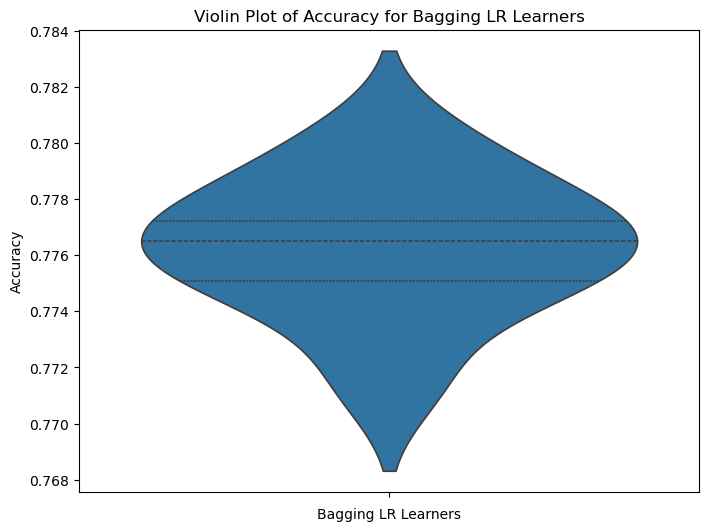

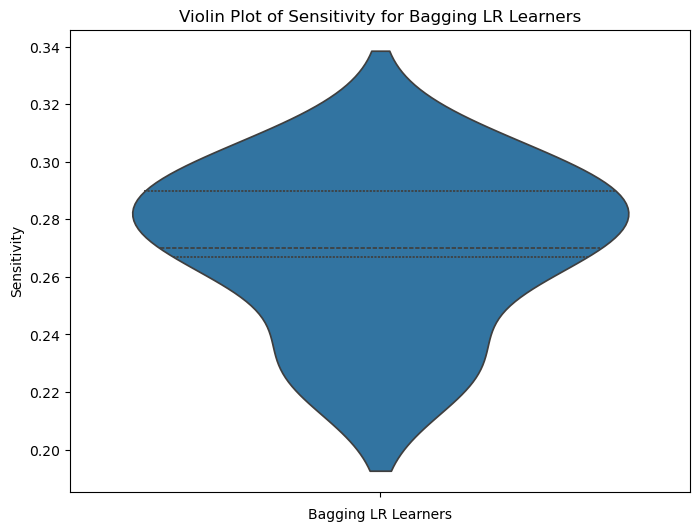

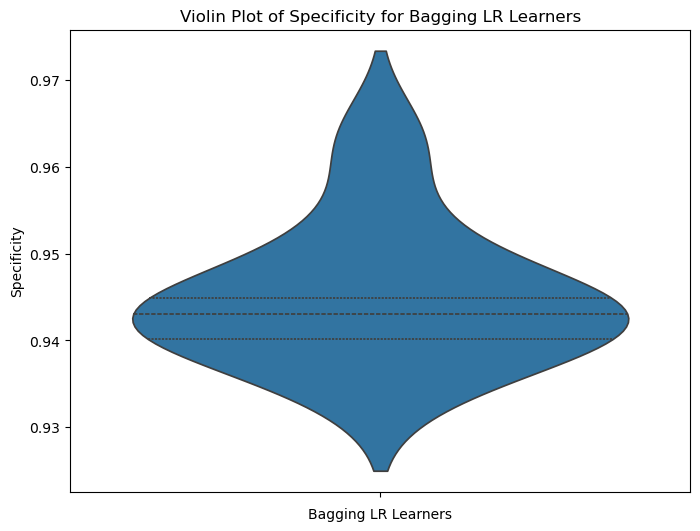

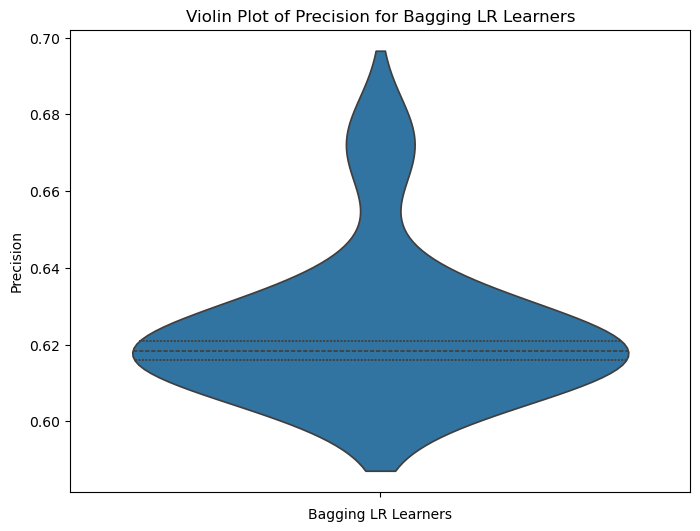

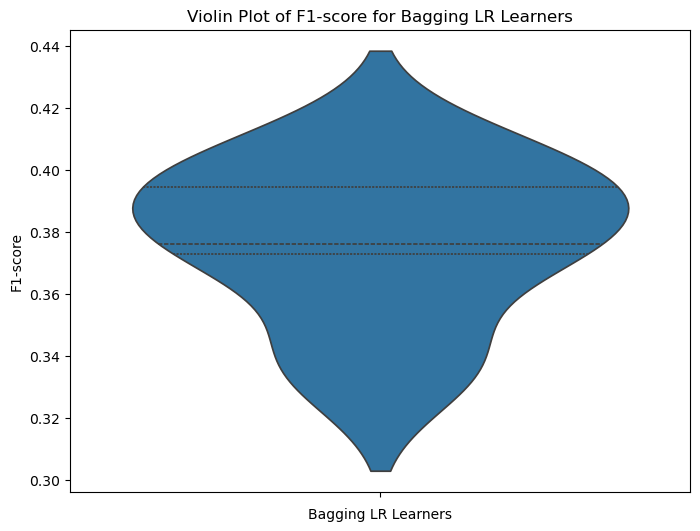

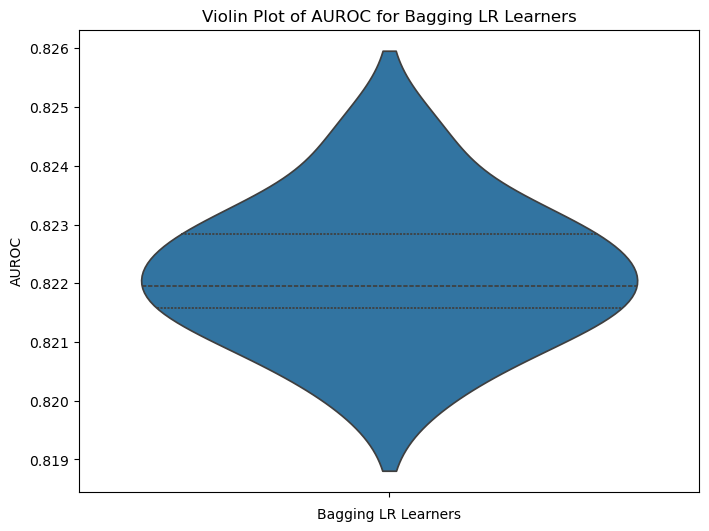

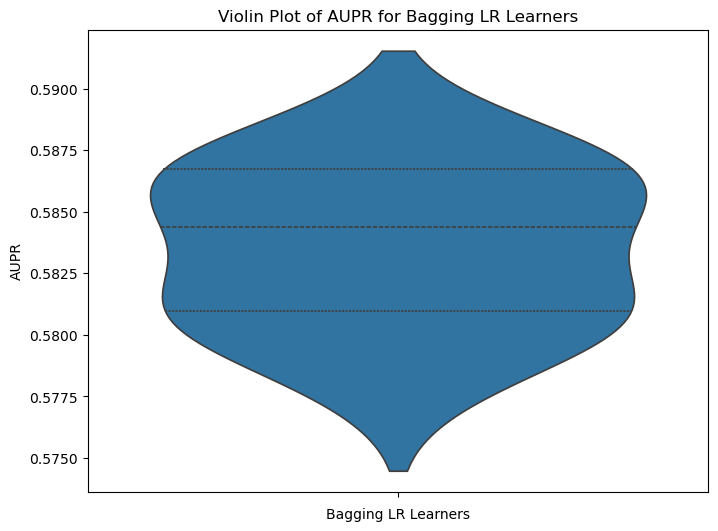

                 mean       std     mean ± std
Accuracy     0.776275  0.002491  0.776 ± 0.002
Sensitivity  0.270833  0.026839  0.271 ± 0.027
Specificity  0.945236  0.008100  0.945 ± 0.008
Precision    0.624466  0.018857  0.624 ± 0.019
F1-score     0.376805  0.025088  0.377 ± 0.025
AUROC        0.822206  0.001186  0.822 ± 0.001
AUPR         0.583501  0.003198  0.584 ± 0.003


In [48]:
#Just Bagging
bagging_clf = BaggingClassifier()
bagging_clf.fit(X_train, y_train)
y_pred = bagging_clf.predictMajority(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Bagging Classifier with Logistic Regression with majority Voting: {accuracy:.2f}")
bagging_clf.evaluate_and_plot(X_test,y_test)
y_proba = bagging_clf.predict_Majority_Proba(X_test)

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Sensitivity': recall_score(y_test, y_pred, pos_label=1),
    'Specificity': recall_score(y_test, y_pred, pos_label=0),
    'Precision': precision_score(y_test, y_pred, zero_division=1),
    'F1-score': f1_score(y_test, y_pred),
    'AUROC': roc_auc_score(y_test, y_proba),
    'AUPR': average_precision_score(y_test, y_proba)
}
performance_metrics.append(metrics)

In [49]:
#with staking
bagging_clf.stack_fit(X_val, y_val)
y_pred = bagging_clf.stack_predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Stacked Bagging Classifier with stacking: {accuracy:.2f}")


Accuracy of Stacked Bagging Classifier with stacking: 0.79


In [50]:
y_proba = bagging_clf.stack_predict_proba(X_test)

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Sensitivity': recall_score(y_test, y_pred, pos_label=1),
    'Specificity': recall_score(y_test, y_pred, pos_label=0),
    'Precision': precision_score(y_test, y_pred, zero_division=1),
    'F1-score': f1_score(y_test, y_pred),
    'AUROC': roc_auc_score(y_test, y_proba),
    'AUPR': average_precision_score(y_test, y_proba)
}
performance_metrics.append(metrics)
comparison_table = pd.DataFrame(performance_metrics)
comparison_table.index = [ 'LR', 'Majority Voting', 'Stacking']
print(comparison_table)



                 Accuracy  Sensitivity  Specificity  Precision  F1-score  \
LR               0.775089     0.258523     0.947768   0.623288  0.365462   
Majority Voting  0.774377     0.272727     0.942070   0.611465  0.377210   
Stacking         0.792171     0.545455     0.874644   0.592593  0.568047   

                    AUROC      AUPR  
LR               0.822566  0.584173  
Majority Voting  0.822315  0.583762  
Stacking         0.835877  0.619385  
